# Crime

## Setup

In [1]:
from matplotlib.colors import ListedColormap 
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from lib import formatting as sd_formatting
import pyodbc 
import toml
import config_logging
import logging
import urllib.request
import pandas as pd
import colorcet as cc

log = logging.getLogger(__name__)
external_ip = urllib.request.urlopen('https://ident.me').read().decode('utf8')

properties = toml.load("./.streamlit/secrets.toml")

database_props = properties[properties["database"]["flavour"]] 


2022-09-02 18:09:52,766 [INFO] numexpr.utils: NumExpr defaulting to 4 threads.


## Reload

In [2]:
### Set up
%load_ext autoreload

%autoreload 3
from data.daos import dao_facade_local as dao_fac
from lib import db_tools as db_tools
from lib import masters_data_analytics_lib as mlib
from lib import stats as stats

db_conn = None
db_conn = db_tools.get_db_conn(database_props)


2022-09-02 18:09:55,293 [DEBUG] matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2022-09-02 18:09:55,302 [DEBUG] matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2022-09-02 18:09:55,813 [INFO] lib.db_tools: DATABASE CONNECTIVITY


## Build the Data

### Search Critera & DAO Access to get all required data

In [3]:
year_from = 2010
year_to   = 2022
city      = "London"
borough   = "Islington"
ward_name = "Holloway"

borough   = "Merton"
ward_name = "Dundonald"

# borough   = "Westminster"    # Highest
# borough   = "Brent"          # Middle
# borough   = "City of London" # Lowest


borough_crime_min_max_year_df = dao_fac.crime_min_max_year(db_conn)

crime_year_from = year_from
crime_year_to   = year_to

crime_year_min = borough_crime_min_max_year_df["MIN_YEAR"].values[0]
crime_year_max = borough_crime_min_max_year_df["MAX_YEAR"].values[0]

log.debug(crime_year_min)
log.debug(crime_year_max)


crime_year_from_orig = crime_year_from
crime_year_to_orig = crime_year_to

if crime_year_from < int(crime_year_min):
    crime_year_from = int(crime_year_min)
elif crime_year_from > int(crime_year_max):
    crime_year_from = int(crime_year_max)

if crime_year_to > int(crime_year_max):
    crime_year_to = int(crime_year_max)
elif crime_year_to < int(crime_year_min):
    crime_year_to = int(crime_year_min)

log.debug(f"earnings orig_year_to    :{crime_year_to_orig}")
log.debug(f"earnings search_year_to  :{crime_year_to}")

search_term = {"year_from":crime_year_from,
               "year_to"  :crime_year_to,
               "borough"  :borough,
               "ward_name":ward_name}

### Now we have a date range that's validated, apply it to the crim data

## borough level crime
borough_crime_per_capita_by_year_df = dao_fac.crime_ranked_by_borough_years(db_conn, search_term)

## ward level crime
##
## It is not possible to do crimes per person at the ward level as we don't have population data at the ward level.
## 

## Years are in descending order
unique_years = borough_crime_per_capita_by_year_df["YEAR"].unique().tolist()

## Move this to the populatkon section
## City Population
city_yearly_population_df = dao_fac.city_yearly_population(db_conn, search_term)

# ## Borough Population
borough_yearly_population_df = dao_fac.borough_yearly_population(db_conn, search_term)

city_yearly_population_ts_df = city_yearly_population_df.copy()
borough_yearly_population_ts_df = borough_yearly_population_df.copy()

city_yearly_population_ts_df = city_yearly_population_ts_df.set_index("YEAR")
city_yearly_population_ts_df["Year"] = city_yearly_population_ts_df.index

borough_yearly_population_ts_df = borough_yearly_population_ts_df.set_index("YEAR")
borough_yearly_population_ts_df["Year"] = borough_yearly_population_ts_df.index

# # city_yearly_population_df["YEAR"] = city_yearly_population_df.index
# # city_yearly_population_df

2022-09-02 18:09:55,992 [DEBUG] root: Retrieving crime min max year


C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


2022-09-02 18:09:56,233 [DEBUG] __main__: 2001
2022-09-02 18:09:56,234 [DEBUG] __main__: 2022
2022-09-02 18:09:56,235 [DEBUG] __main__: earnings orig_year_to    :2022
2022-09-02 18:09:56,237 [DEBUG] __main__: earnings search_year_to  :2022
2022-09-02 18:09:56,238 [DEBUG] root: Retrieving Crime Ranked By Borough Years


C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


2022-09-02 18:10:38,306 [DEBUG] root: city_population
2022-09-02 18:10:38,325 [DEBUG] root: city_population


C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [4]:
borough_crime_per_capita_by_year_df

,YEAR,LAD_CODE,BOROUGH,BOROUGH_TOTAL_CRIME,BOROUGH_POPULATION,CRIMES_PER_PERSON,RANK
0,2022,E09000033,Westminster,27278.0,257302.0,0.10602,1
1,2022,E09000007,Camden,13785.0,257615.0,0.05351,2
2,2022,E09000019,Islington,11071.0,240594.0,0.04602,3
3,2022,E09000030,Tower Hamlets,13436.0,296813.0,0.04527,4
4,2022,E09000020,Kensington and Chelsea,8237.0,185320.0,0.04445,5
...,...,...,...,...,...,...,...
424,2010,E09000029,Sutton,12591.0,187266.0,0.06724,29
425,2010,E09000015,Harrow,15183.0,235435.0,0.06449,30
426,2010,E09000027,Richmond upon Thames,11449.0,184158.0,0.06217,31
427,2010,E09000004,Bexley,13991.0,228483.0,0.06123,32


### Build Data For the Plot

In [5]:
index = []
data  = []
columns = ["CITY_MAX_IN_YEAR", "CITY_MEAN_IN_YEAR", "CITY_MIN_IN_YEAR", "BOROUGH_MEAN_IN_YEAR"]

unique_years_plot = sorted(unique_years)

for year in unique_years_plot:
    data_row = []
    city_max_in_year     = borough_crime_per_capita_by_year_df[borough_crime_per_capita_by_year_df["YEAR"] == year]["CRIMES_PER_PERSON"].max()
    city_mean_in_year    = borough_crime_per_capita_by_year_df[borough_crime_per_capita_by_year_df["YEAR"] == year]["CRIMES_PER_PERSON"].mean()
    city_min_in_year     = borough_crime_per_capita_by_year_df[borough_crime_per_capita_by_year_df["YEAR"] == year]["CRIMES_PER_PERSON"].min()
    borough_mean_in_year = borough_crime_per_capita_by_year_df[(borough_crime_per_capita_by_year_df["YEAR"] == year) &
                                                             (borough_crime_per_capita_by_year_df["BOROUGH"] == borough)]["CRIMES_PER_PERSON"].values[0]
        
    # max_in_year_fmt          = "£{:,.0f}".format(city_max_in_year)
    # mean_in_year_fmt         = "£{:,.0f}".format(city_mean_in_year)
    # min_in_year_fmt          = "£{:,.0f}".format(city_min_in_year)
    # borough_mean_in_year_fmt = "£{:,.0f}".format(borough_mean_in_year)
    # country_mean_in_year_fmt = "£{:,.0f}".format(country_mean_in_year)
        
    index.append(year)
    data_row.append(city_max_in_year)
    data_row.append(city_mean_in_year)
    data_row.append(city_min_in_year)
    data_row.append(borough_mean_in_year)
    data.append(data_row)
    # log.debug(f"[{borough}]-{year} - borough mean:{borough_mean_in_year_fmt} - city max:{max_in_year_fmt} - city mean:{mean_in_year_fmt} - city min:{min_in_year_fmt} - country mean:{country_mean_in_year_fmt}")
    
crime_ts_df = pd.DataFrame(data=data, index=index, columns=columns)    
crime_ts_df["Year"] = crime_ts_df.index


In [6]:
crime_ts_df

,CITY_MAX_IN_YEAR,CITY_MEAN_IN_YEAR,CITY_MIN_IN_YEAR,BOROUGH_MEAN_IN_YEAR,Year
2010,0.28522,0.098684,0.0,0.07282,2010
2011,0.29466,0.096769,0.0,0.07191,2011
2012,0.27801,0.092321,0.0,0.06695,2012
2013,0.24108,0.081904,0.0,0.05781,2013
2014,0.20967,0.079822,0.0,0.05663,2014
2015,0.20626,0.082426,0.0,0.05920,2015
2016,0.20802,0.084242,0.0,0.06082,2016
2017,0.23350,0.089785,0.0,0.06298,2017
2018,0.25511,0.090055,0.0,0.06253,2018
2019,0.32528,0.097049,0.0,0.06459,2019


In [7]:
crime_changed_search_date_dates     = f"The new date is {crime_year_to}" if crime_year_from == crime_year_to else \
                                         f"The new dates are {crime_year_from} to {crime_year_to}"

crime_changed_search_s              = f" was" if crime_year_from == crime_year_to else \
                                         f"s were"

crime_changed_search_date_narrative = f"Your original search date{crime_changed_search_s} changed to match the date range of the earnings data. {crime_changed_search_date_dates}" \
                                         if ((crime_year_from != crime_year_from_orig) or \
                                             (crime_year_to   != crime_year_to_orig)) else ""

log.debug(f"\n{crime_changed_search_date_narrative}")

2022-09-02 18:10:38,880 [DEBUG] __main__: 



## Build the Time Series Plot

### Text Description of Plot

In [8]:
crime_plot_desctiption_year_range = f"between {year_from} and {year_to}" if year_to != year_from else f"for {year_to}"
crime_plot_description_narrative = f"The graph below compares the crimes per person in the {city} borough of {borough} {crime_plot_desctiption_year_range}."
log.debug(f"\n{crime_plot_description_narrative}")

2022-09-02 18:10:38,986 [DEBUG] __main__: 
The graph below compares the crimes per person in the London borough of Merton between 2010 and 2022.


In [9]:
crime_ts_df

,CITY_MAX_IN_YEAR,CITY_MEAN_IN_YEAR,CITY_MIN_IN_YEAR,BOROUGH_MEAN_IN_YEAR,Year
2010,0.28522,0.098684,0.0,0.07282,2010
2011,0.29466,0.096769,0.0,0.07191,2011
2012,0.27801,0.092321,0.0,0.06695,2012
2013,0.24108,0.081904,0.0,0.05781,2013
2014,0.20967,0.079822,0.0,0.05663,2014
2015,0.20626,0.082426,0.0,0.05920,2015
2016,0.20802,0.084242,0.0,0.06082,2016
2017,0.23350,0.089785,0.0,0.06298,2017
2018,0.25511,0.090055,0.0,0.06253,2018
2019,0.32528,0.097049,0.0,0.06459,2019


### Crime Time Series Plot

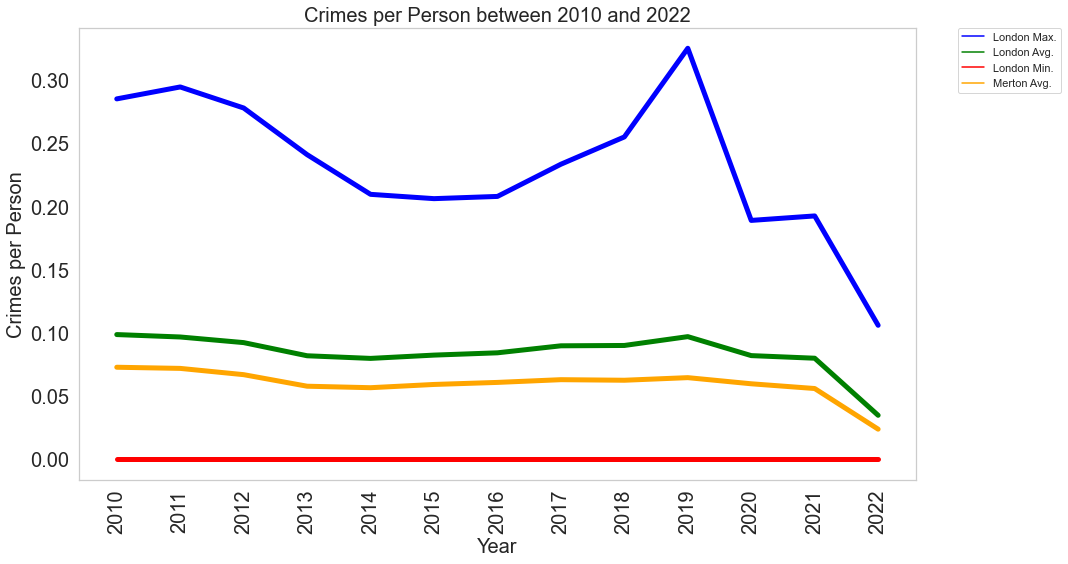

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


x_fig_size = 15
y_fig_size = 8

## Set the size
sns.set(rc={"figure.figsize":(x_fig_size, y_fig_size)})

## Set the theme
sns.set_style("whitegrid")

marker = "" if year_from != year_to else "o"

fig, ax = plt.subplots()
sns.lineplot(data=crime_ts_df, x="Year", y="CITY_MAX_IN_YEAR",     ax=ax, label=f"{city} Max.",    color='blue', marker=marker)
sns.lineplot(data=crime_ts_df, x="Year", y="CITY_MEAN_IN_YEAR",    ax=ax, label=f"{city} Avg.",    color='green', marker=marker)
sns.lineplot(data=crime_ts_df, x="Year", y="CITY_MIN_IN_YEAR",     ax=ax, label=f"{city} Min.",    color='red', marker=marker)
sns.lineplot(data=crime_ts_df, x="Year", y="BOROUGH_MEAN_IN_YEAR", ax=ax, label=f"{borough} Avg.", color='orange', marker=marker)

plot_title = "Crimes per Person between {} and {}".format(year_from, year_to) if year_from != year_to else \
             "Crimes per Person for {}".format(year_to)

ax.set_title(plot_title, fontsize=20)
ax.set_ylabel("Crimes per Person", fontsize=20)
ax.set_xlabel("Year", fontsize=20)
ax.tick_params(axis="x", labelrotation=90)

ax.legend(title="legend")
ax.legend(loc="upper right")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

for line in ax.get_lines():
    line.set_linewidth(5)
    line.set_ms(10)

ax.grid(False)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# ax2 = plt.twinx()
# ax2.grid(False)
# # sns.lineplot(data=city_yearly_population_ts_df, x="Year", y="POPULATION_FOR_YEAR_CITY" , color="b", ax=ax2)
# sns.lineplot(data=borough_yearly_population_ts_df, x="Year", y="POPULATION_FOR_YEAR_CITY" , color="b", ax=ax2)

plt.tight_layout()

crime_plot = plt.gcf()

# plt.show()



### Crime Time Series Narrative

In [11]:
## The maximum year from the data set
crime_latest_year = borough_crime_per_capita_by_year_df["YEAR"].max()
crime_latest_year = year_to

## The Average earnings across all the boroughs for that year
borough_crime_ranking_filtered_max_year_df =  borough_crime_per_capita_by_year_df[borough_crime_per_capita_by_year_df["YEAR"].astype(int) == crime_latest_year]


latest_city_max_mean_crime_pp     = borough_crime_ranking_filtered_max_year_df["CRIMES_PER_PERSON"].max()
latest_city_mean_mean_crime_pp    = borough_crime_ranking_filtered_max_year_df["CRIMES_PER_PERSON"].mean()
latest_borough_mean_crime_pp      = borough_crime_ranking_filtered_max_year_df[borough_crime_ranking_filtered_max_year_df["BOROUGH"] == borough]["CRIMES_PER_PERSON"].values[0]
latest_city_min_mean_crime_pp     = borough_crime_ranking_filtered_max_year_df["CRIMES_PER_PERSON"].min()

def prepend(a, b):
  ret_val = ""
  if b != 0:
      if a > b:
        ret_val = "significantly " if a/b >= 2.0 else ""
      elif a < b:
        ret_val = "significantly " if b/a >= 2.0 else ""
  return ret_val

def above_below_equal(a, b):
    ret_val = ""
    if b != 0:
        if a > b:
            if a/b <= 1.1:
                ret_val = "comparable to"
            else:
                ret_val = "above"
        elif a < b:
            if b/a <= 1.1:
                ret_val = "comparable to"
            else:
                ret_val = "below"
        else:
            ret_val = "equal to"
    else:
        ret_val = "above"

    return ret_val

## Format the latest for the text
### City
latest_city_max_mean_crime_pp_fmt     = "{:,.4f}".format(float(latest_city_max_mean_crime_pp))
latest_city_mean_mean_crime_pp_fmt    = "{:,.4f}".format(float(latest_city_mean_mean_crime_pp))
latest_borough_mean_crime_pp_fmt      = "{:,.4f}".format(float(latest_borough_mean_crime_pp))
latest_city_min_mean_crime_pp_fmt     = "{:,.4f}".format(float(latest_city_min_mean_crime_pp))

## Preamble
part_01 = f"The {crime_latest_year} crimes per person in {borough} is {latest_borough_mean_crime_pp_fmt}"

## CITY BOROUGH MEAN COMPARE TO CITY MEAN MEAN [X]
mean_explanation = f"{prepend(latest_borough_mean_crime_pp, latest_city_mean_mean_crime_pp)}{above_below_equal(latest_borough_mean_crime_pp, latest_city_mean_mean_crime_pp)}"
part_02 = f". This is {mean_explanation} the average for {city} in the same period of {latest_city_mean_mean_crime_pp_fmt}"


# CITY BOROUGH MEAN COMPARE TO CITY MAX MEAN [X]
max_explanation = f"{prepend(latest_borough_mean_crime_pp, latest_city_max_mean_crime_pp)}{above_below_equal(latest_borough_mean_crime_pp, latest_city_max_mean_crime_pp)}"
part_03 = f" and is {max_explanation} the maximum of {latest_city_max_mean_crime_pp_fmt}"


## CITY BOROUGH MEAN COMPARE TO CITY MIN MEAN [X]
min_explanation = f"{prepend(latest_borough_mean_crime_pp, latest_city_min_mean_crime_pp)}{above_below_equal(latest_borough_mean_crime_pp, latest_city_min_mean_crime_pp)}"
part_04 = f". It is {min_explanation} the minimum of {latest_city_min_mean_crime_pp_fmt}"

from scipy import stats
y = [crime_ts_df["BOROUGH_MEAN_IN_YEAR"].tolist()]
x = crime_ts_df.index.astype(int).tolist()

part_05 = ""

if len(x) >= 3:

    # log.debug(y)
    # log.debug(x)

    slope, intercept, r, p, std_err = stats.linregress(x, y)

    if slope == 0:
        rate = "has remained level"
    elif slope > 0:    
        if slope >= 0.1:
            rate = "has slightly increased"
        elif slope >=  0.5:
            rate = "has moderatly increased"
        else:
            rate = "has greatly increased"
    else:
        if slope <= - 0.1:
            rate = "has slightly decreased"
        elif slope <= - 0.5:
            rate = "has moderatly decreased"
        else:
            rate = "has greatly decreasd"

    part_05 = f". Over the period {year_from} to {year_to} crimes per person in {borough} {rate}."

## Borough population trend 
part_06 = ""
part_07 = ""

y = [borough_yearly_population_df["POPULATION_FOR_YEAR_CITY"].tolist()]
x = borough_yearly_population_df.index.astype(int).tolist()

if len(x) >= 3:

    ## Borough population trend.
    borough_population_start = y[0][0]
    borough_population_start_fmt = "{:,.0f}".format(borough_population_start)
    
    borough_population_end = y[0][-1]
    borough_population_end_fmt = "{:,.0f}".format(borough_population_end)
    
    slope, intercept, r, p, std_err = stats.linregress(x, y)

    inc_dec_narrative = ""
    if slope == 0:
        rate = "has remained level"
    elif slope > 0:    
        inc_dec = borough_population_end - borough_population_start
        inc_dec_fmt = "{:,.0f}".format(inc_dec)
        inc_dec_narrative = f" which is an increase of {inc_dec_fmt}"
        
        if slope >= 0.1:
            rate = "has slightly increased"
        elif slope >=  0.5:
            rate = "has moderatly increased"
        else:
            rate = "has greatly increased"
    else:
        inc_dec = borough_population_start - borough_population_end 
        inc_dec_fmt = "{:,.0f}".format(inc_dec)
        inc_dec_narrative = f" which is a decrease of {inc_dec_fmt}"
        
        if slope <= - 0.1:
            rate = "has slightly decreased"
        elif slope <= - 0.5:
            rate = "has moderatly decreased"
        else:
            rate = "has greatly decreasd"

    part_06 = f" Over the same period the population of {borough} {rate} starting at {borough_population_start_fmt} and ending at {borough_population_end_fmt} {inc_dec_narrative}."

    ## City population trend
    y = [city_yearly_population_ts_df["POPULATION_FOR_YEAR_CITY"].tolist()]
    x = city_yearly_population_ts_df.index.astype(int).tolist()

    city_population_start = y[0][0]
    city_population_start_fmt = "{:,.0f}".format(city_population_start)
    
    city_population_end = y[0][-1]
    city_population_end_fmt = "{:,.0f}".format(city_population_end)
    
    slope, intercept, r, p, std_err = stats.linregress(x, y)

    inc_dec_narrative = ""
    if slope == 0:
        rate = "has remained level"
    elif slope > 0:    
        inc_dec = city_population_end - city_population_start
        inc_dec_fmt = "{:,.0f}".format(inc_dec)
        inc_dec_narrative = f" which is an increase of {inc_dec_fmt}"
        
        if slope >= 0.1:
            rate = "has slightly increased"
        elif slope >=  0.5:
            rate = "has moderatly increased"
        else:
            rate = "has greatly increased"
    else:
        inc_dec = city_population_start - city_population_end 
        inc_dec_fmt = "{:,.0f}".format(inc_dec)
        inc_dec_narrative = f" which is a decrease of {inc_dec_fmt}"
        
        if slope <= - 0.1:
            rate = "has slightly decreased"
        elif slope <= - 0.5:
            rate = "has moderatly decreased"
        else:
            rate = "has greatly decreasd"

    part_07 = f" {city}'s population {rate} from {city_population_start_fmt} and ending at {city_population_end_fmt} {inc_dec_narrative}."
    
    
    ### Put them all together  [ ]
    crime_narrative = f"\n{part_01}{part_02}{part_03}{part_04}{part_05}{part_06}{part_07}"

    log.debug(crime_narrative)


2022-09-02 18:10:43,776 [DEBUG] __main__: 
The 2022 crimes per person in Merton is 0.0238. This is below the average for London in the same period of 0.0348 and is significantly below the maximum of 0.1060. It is above the minimum of 0.0000. Over the period 2010 to 2022 crimes per person in Merton has greatly decreasd. Over the same period the population of Merton has slightly increased starting at 196,669 and ending at 233,264  which is an increase of 36,595. London's population has slightly increased from 8,054,622 and ending at 9,553,385  which is an increase of 1,498,763.


## Build Bump Chart Plot

In [12]:
years_sorted = borough_crime_per_capita_by_year_df["YEAR"].sort_values().drop_duplicates()
first_year = years_sorted.iloc[0]
borough_sort_order = borough_crime_per_capita_by_year_df.loc[borough_crime_per_capita_by_year_df["YEAR"]==first_year]["BOROUGH"]
top_borough = borough_sort_order.iloc[0]
mid_borough = borough_sort_order.iloc[16]
bottom_borough = borough_sort_order.iloc[-1]

## Loop through the boroughs in the sort order of first year
all_borough_ranking_by_year = []

## BOROUGH LOOP
for _borough in borough_sort_order:

    borough_ranking_by_year_list = []

    ## Add the Borough
    borough_ranking_by_year_list.append(_borough)

    ## YEAR LOOP
    for year in years_sorted:

        borough_ranking_for_year = borough_crime_per_capita_by_year_df.loc[(borough_crime_per_capita_by_year_df["BOROUGH"]==_borough) &
                                      (borough_crime_per_capita_by_year_df["YEAR"]==year)]["RANK"].values[0]

        borough_ranking_by_year_list.append(borough_ranking_for_year)

    all_borough_ranking_by_year.append(borough_ranking_by_year_list)

columns = ["Borough"] + list(years_sorted)

all_borough_ranking_by_year_df = pd.DataFrame(all_borough_ranking_by_year, columns=columns).set_index("Borough")

tmb_borough_ranking_by_year_df = all_borough_ranking_by_year_df.copy()


### Crime Time Series Bump Chart Narrative

In [13]:
crime_bump_chart_date_range = f"over the period {year_from} to {year_to}" if year_from != year_to else f"for {year_to}"

crime_bump_chart_narrative = f"How {borough} ranks with the other London boroughs {crime_bump_chart_date_range} can be seen below. Ranking is top to bottom, with the top representing the highest crimes per person rate."
log.debug(f"\n{crime_bump_chart_narrative}")

2022-09-02 18:10:44,308 [DEBUG] __main__: 
How Merton ranks with the other London boroughs over the period 2010 to 2022 can be seen below. Ranking is top to bottom, with the top representing the highest crimes per person rate.


### Earnings Time Series Bump Chart

2022-09-03 13:04:08,691 [DEBUG] matplotlib.axes._base: top of Axes not in the figure, so title not moved
2022-09-03 13:04:08,930 [DEBUG] matplotlib.axes._base: top of Axes not in the figure, so title not moved
2022-09-03 13:04:09,013 [DEBUG] matplotlib.axes._base: top of Axes not in the figure, so title not moved
2022-09-03 13:04:09,084 [DEBUG] matplotlib.axes._base: top of Axes not in the figure, so title not moved
2022-09-03 13:04:09,130 [DEBUG] matplotlib.axes._base: top of Axes not in the figure, so title not moved


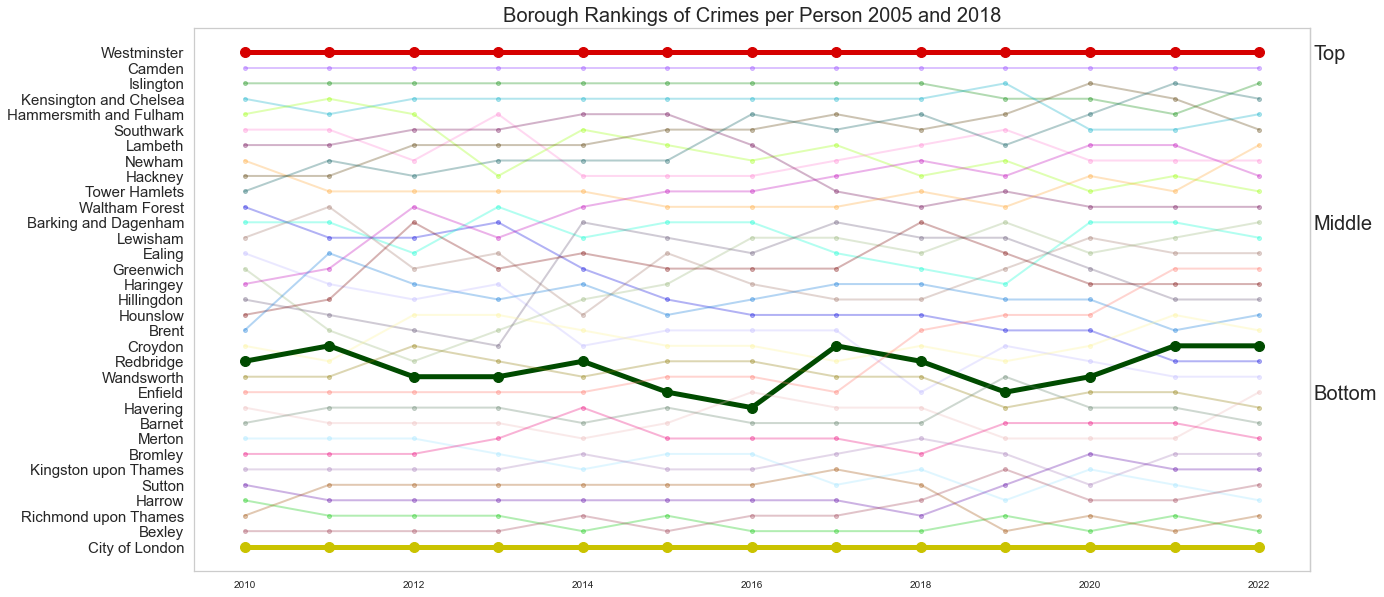

In [205]:
####
#### CREATE THE PLOTS - APPENDICES VERSION
#### 

palette = sns.color_palette(cc.glasbey, n_colors=len(borough_sort_order))
my_cmap = ListedColormap(sns.color_palette(palette).as_hex())
ax = all_borough_ranking_by_year_df.T.plot(figsize=(20, 10), marker="o",  ms=5, cmap=my_cmap)

ax.grid(False)
ax.set_title("Borough Rankings of Crimes per Person {} and {}".format(year_from, year_to), fontsize=20)
plt.xticks(fontsize=10)


## Generate labels from the Borough names for the Y Axis
plt.yticks(range(1, len(borough_sort_order)+1), [borough_sort_order.iloc[i] for i in range(len(borough_sort_order))])
plt.yticks(fontsize=15)

## Secondary Y axis to show top middle and bottom
ax2 = ax.secondary_yaxis('right')
ax2.tick_params(labelsize = 20, length=0)
ax2.set_yticks(ax.get_yticks().tolist())
ax2.set_yticklabels(["Top", "", "", "", "", "", "", "", "", "", "", "Middle", "", "", "", "", "", "", "", "", "", "", "Bottom", "", "", "", "", "", "", "", "", "",""])
ax2.minorticks_off()

plt.gca().invert_yaxis()
plt.gca().get_legend().remove()

for line in ax.get_lines():
    # if (line.get_label() == borough) or (line.get_label() == top_borough) or (line.get_label() == mid_borough) or (line.get_label() == bottom_borough):
    if (line.get_label() == borough) or (line.get_label() == top_borough) or (line.get_label() == bottom_borough):
        line.set_linewidth(5)
        line.set_ms(10)
    else:
        line.set_linewidth(2)
        line.set_ms(4)
        line.set_alpha(0.3)

crime_bump_plot = plt.gcf()         
# plt.show(block=True)



### Percenrage at above or below that ranking


In [160]:
all_borough_ranking_by_year_df

# borough = "Westminster"
# borough = "Tower Hamlets"
borough = "Haringey"
borough = "City of London"
# borough = ["Redbridge","Waltham Forest","Barnet"]



for borough in all_borough_ranking_by_year_df.index.to_list():
# for borough in borough:
 
    borough_yearly_rankings = all_borough_ranking_by_year_df[all_borough_ranking_by_year_df.index == borough]


    ## Leave it blank if only one year's worth of data
    crime_narrative_nn = "" 
    if year_from != year_to:
        top = 0
        middle = 0
        bottom = 0

        above = 0
        same  = 1
        below = 0
        start_rank = None

        for column in borough_yearly_rankings:
            rank = borough_yearly_rankings[column].values[0]
            if rank <= 11:
                top += 1
            elif rank >= 23:
                bottom +=1
            else:
                middle += 1


            if start_rank == None:
                start_rank = rank
            else:    
                if rank > start_rank:
                    below += 1
                elif rank < start_rank:
                    above += 1
                else:
                    same +=1

        all = top + middle + bottom
        top_pct = round((top/all*100),0)
        middle_pct = round((middle/all*100),0)
        bottom_pct = round((bottom/all*100),0)

        all = above + same + below
        above_pct = round((above/all*100),0)
        same_pct  = round((same/all*100),0)
        below_pct  = round((below/all*100),0)

        def place(pct, list=["never", "occasionally", "frequently", "constantly", "always"]):
            ret_val = list[0] if pct == 0 else \
                      list[1] if pct  < 33 else \
                      list[2] if pct < 66 else \
                      list[3] if pct < 100 else \
                      list[4]
            
            return ret_val

        def not_empty_count(list_items):
            not_empty_count = 0
            for item in list_items:
                if not item:
                    not_empty_count +=1
            return not_empty_count

        def stf(str_list):
            ret_val = 0
            ret_val += 4 if str_list[0] else 0
            ret_val += 2 if str_list[1] else 0
            ret_val += 1 if str_list[2] else 0

            return ret_val

        crime_vertical_narrative_top    = "" if top_pct == 0 else f" {place(top_pct)} in the higher crime rate boroughs"
        middle_inc_crime_rate_borough   = "" if "crime rate boroughs" in crime_vertical_narrative_top else " crime rate boroughs" 
        crime_vertical_narrative_middle = "" if middle_pct == 0 else f" {place(middle_pct)} in the middle{middle_inc_crime_rate_borough}"
        bottom_inc_crime_rate_borough   = "" if ("crime rate boroughs" in crime_vertical_narrative_middle) or ("crime rate boroughs" in crime_vertical_narrative_top) else " crime rate boroughs" 
        crime_vertical_narrative_bottom = "" if bottom_pct == 0 else f" {place(bottom_pct)} in the bottom{bottom_inc_crime_rate_borough}"
        
        ## The sentance has the same set of punctuations, but with differening needs for spaces 
        v_punct_list_pos_1 = ["", "", "", "", "", " and", ", "]
        v_punct_list_pos_2 = ["", "", " and", "", " and is ", "", " and"]
        
        h_punct_list_pos_1 = ["", "", "", "", "", " and ", ", "]
        h_punct_list_pos_2 = ["", "", " and ", "", " and ", "", " and "]

        comma_or_and_1_v = v_punct_list_pos_1[stf([crime_vertical_narrative_top,crime_vertical_narrative_middle, crime_vertical_narrative_bottom])-1]
        comma_or_and_2_v = v_punct_list_pos_2[stf([crime_vertical_narrative_top,crime_vertical_narrative_middle, crime_vertical_narrative_bottom])-1]

        crime_vertical_narrative = f"{borough} is{crime_vertical_narrative_top}{comma_or_and_1_v}{crime_vertical_narrative_middle}{comma_or_and_2_v}{crime_vertical_narrative_bottom}"

        crime_horizontal_up   = "" if "never" in place(above_pct) else f"{place(above_pct, list=['never', 'sometimes', 'frequently', 'very frequently', 'always'])} moves up"
        crime_horizontal_same = "" if "never" in place(same_pct)  else f"{place(same_pct,  list=['never', 'sometimes', 'frequently', 'very frequently', 'always'])} stays level"
        crime_horizontal_down = "" if "never" in place(below_pct) else f"{place(below_pct, list=['never', 'sometimes', 'frequently', 'very frequently', 'always'])} moves down"

        comma_or_and_1_h = h_punct_list_pos_1[stf([crime_horizontal_up, crime_horizontal_same, crime_horizontal_down])-1]
        comma_or_and_2_h = h_punct_list_pos_2[stf([crime_horizontal_up, crime_horizontal_same, crime_horizontal_down])-1]

        crime_horizontal_narrative = f"{crime_horizontal_up}{comma_or_and_1_h}{crime_horizontal_same}{comma_or_and_2_h}{crime_horizontal_down}"
        # log.debug(crime_vertical_narrative)
        # log.debug(crime_horizontal_narrative)

        crime_narrative_combined = f"{crime_vertical_narrative}. It {crime_horizontal_narrative}."
        log.debug(crime_narrative_combined)
    
# continualy, frequently, ocasionally, never

# horizontally
# never|ocasionall|frequently|continually moves up|down|stays the same




2022-09-03 11:10:48,576 [DEBUG] __main__: Westminster is always in the higher crime rate boroughs. It always stays level.
2022-09-03 11:10:48,580 [DEBUG] __main__: Camden is always in the higher crime rate boroughs. It always stays level.
2022-09-03 11:10:48,583 [DEBUG] __main__: Islington is always in the higher crime rate boroughs. It very frequently stays level and sometimes moves down.
2022-09-03 11:10:48,586 [DEBUG] __main__: Kensington and Chelsea is always in the higher crime rate boroughs. It sometimes moves up, frequently stays level and sometimes moves down.
2022-09-03 11:10:48,588 [DEBUG] __main__: Hammersmith and Fulham is always in the higher crime rate boroughs. It sometimes moves up, sometimes stays level and very frequently moves down.
2022-09-03 11:10:48,591 [DEBUG] __main__: Southwark is always in the higher crime rate boroughs. It sometimes moves up, sometimes stays level and very frequently moves down.
2022-09-03 11:10:48,596 [DEBUG] __main__: Lambeth is always in t

In [119]:
all_borough_ranking_by_year_df.index.to_list()

['Westminster',
 'Camden',
 'Islington',
 'Kensington and Chelsea',
 'Hammersmith and Fulham',
 'Southwark',
 'Lambeth',
 'Newham',
 'Hackney',
 'Tower Hamlets',
 'Waltham Forest',
 'Barking and Dagenham',
 'Lewisham',
 'Ealing',
 'Greenwich',
 'Haringey',
 'Hillingdon',
 'Hounslow',
 'Brent',
 'Croydon',
 'Redbridge',
 'Wandsworth',
 'Enfield',
 'Havering',
 'Barnet',
 'Merton',
 'Bromley',
 'Kingston upon Thames',
 'Sutton',
 'Harrow',
 'Richmond upon Thames',
 'Bexley',
 'City of London']

In [ ]:
# mostly moves down
def stf(str, pos):
    return pos if str else 0

# print(crime_narrative_nn)
log.debug(stf("",4) + stf("",2) + stf("1", 1))
log.debug(stf("",4) + stf("1",2) + stf("", 1))
log.debug(stf("",4) + stf("1",2) + stf("1", 1))
log.debug(stf("1",4) + stf("",2) + stf("", 1))
log.debug(stf("1",4) + stf("",2) + stf("1", 1))
log.debug(stf("1",4) + stf("1",2) + stf("", 1))
log.debug(stf("1",4) + stf("1",2) + stf("1", 1))

def stf(str_list):
    ret_val = 0
    ret_val += 4 if str_list[0] else 0
    ret_val += 2 if str_list[1] else 0
    ret_val += 1 if str_list[2] else 0
    
    return ret_val

log.debug(stf([ "",  "", "1"]))
log.debug(stf([ "", "1",  ""]))
log.debug(stf([ "", "1", "1"]))
log.debug(stf(["1",  "",  ""]))
log.debug(stf(["1",  "", "1"]))
log.debug(stf(["1", "1",  ""]))
log.debug(stf(["1", "1", "1"]))



In [16]:
# top_pct_list = [100,66,65,33,32,1,0]
# for top_pct in top_pct_list:

def pct_amount(pct) -> str:
    print(pct)
    pct_amount_fmt = "always {}"    if  pct==100 else \
                "mostly {}"    if (pct <100 and pct >=66) else \
                "sometimes {}" if (pct  <66 and pct >=33) else \
                "rarely {}"    if (pct  <33 and pct >=1)  else \
                "" 
    return pct_amount_fmt

print(pct_amount(0))

top_narrative = pct_amount(top_pct).format("in the top third")
middle_narrative = pct_amount(middle_pct).format("in the middle third")
bottom_narrative = pct_amount(bottom_pct).format("in the bottom third")
# print(top_pct)
# print(middle_pct/)
# print(bottom_pct)
print(f"X is {top_narrative} {middle_narrative} {bottom_narrative}")

0

100.0
0.0
0.0
X is always in the top third  


### Build the table for year on year benchmark crimes per person

In [17]:

# all_borough_ranking_by_year_df

## Change the order of unique years back to Descednding
unique_years_bump = sorted(unique_years, reverse=True)

crime_benchmark_data = []

## Loop through the years to create our data frame for benchmarking


## Using the Bump Chart Data
for year in unique_years_bump:
    ## Vertical Slice  
    borough_year_data = tmb_borough_ranking_by_year_df[year] 

    ## Loop through each borough
    idx = 0;

    ## Add uear to the dataframe row
    crime_benchmark_data_row = []
    crime_benchmark_data_row.append(str(year))

    for borough_year in borough_year_data.index:
        ranking = borough_year_data[idx]     
        
        borough_max_min_crime_year = crime_ts_df[crime_ts_df["Year"].astype(int) == int(year)][["CITY_MAX_IN_YEAR", "CITY_MIN_IN_YEAR"]]

        max_borough_crime_for_year = borough_max_min_crime_year["CITY_MAX_IN_YEAR"]
        max_borough_crime_for_year_fmt = "{:,.4f}".format(float(max_borough_crime_for_year))

        min_borough_crime_for_year = borough_max_min_crime_year["CITY_MIN_IN_YEAR"]
        min_borough_crime_for_year_fmt = "{:,.4f}".format(float(min_borough_crime_for_year))

        # log.debug(ranking)
        if ranking == 1:
          max_str = f"{borough_year} - {max_borough_crime_for_year_fmt}"

        if ranking == 33:
          min_str = f"{borough_year} - {min_borough_crime_for_year_fmt}"

        idx += 1

    ## Min
    crime_benchmark_data_row.append(min_str)
    
    ## Our borough's 
    search_borough_crime_for_year = crime_ts_df[crime_ts_df["Year"] == year]["BOROUGH_MEAN_IN_YEAR"].values[0]
    search_borough_crime_for_year_fmt = "{:,.4f}".format(float(search_borough_crime_for_year))
    crime_benchmark_data_row.append(search_borough_crime_for_year_fmt)

    ## Max
    crime_benchmark_data_row.append(max_str)
    
    crime_benchmark_data.append(crime_benchmark_data_row)

crime_benchmark_data_df = pd.DataFrame(data=crime_benchmark_data, columns=["Year", "Borough with Lowest Crime per Person", f"{borough} Crime per Person", "Borough with Highest Crime per Person"])
crime_benchmark_data_df = crime_benchmark_data_df.set_index("Year")



from IPython.display import HTML
styles = [
  dict(selector="tr", props=[("font-size", "120%"),
                             ("text-align", "right")])
]

crime_benchamark_data_df_html = (crime_benchmark_data_df.style.set_table_styles(styles))


In [18]:
crime_benchamark_data_df_html

,Borough with Lowest Crime per Person,Merton Crime per Person,Borough with Highest Crime per Person
Year,,,
2022,City of London - 0.0000,0.0238,Westminster - 0.1060
2021,City of London - 0.0000,0.0560,Westminster - 0.1926
2020,City of London - 0.0000,0.0597,Westminster - 0.1890
2019,City of London - 0.0000,0.0646,Westminster - 0.3253
2018,City of London - 0.0000,0.0625,Westminster - 0.2551
2017,City of London - 0.0000,0.0630,Westminster - 0.2335
2016,City of London - 0.0000,0.0608,Westminster - 0.2080
2015,City of London - 0.0000,0.0592,Westminster - 0.2063
2014,City of London - 0.0000,0.0566,Westminster - 0.2097


### Top 5 Crimes for Year in Borough and Ward

In [19]:
borough_top_crime_per_by_year_df = dao_fac.crime_major_category_in_borough_years(db_conn, search_term)

ward_top_crime_per_by_year_df = dao_fac.crime_major_category_in_borough_ward_years(db_conn, search_term)

2022-09-02 18:10:46,172 [DEBUG] root: Retrieving Crim Major categories top 5 for borough in year


C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


2022-09-02 18:11:04,802 [DEBUG] root: Retrieving Crim Major categories for a ward top 5 for borough in year


C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [20]:
borough_top_crime_per_by_year_df

,YEAR,MAJOR_CATEGORY,BOROUGH_TOTAL_CRIME,RANK
0,2022,Violence Against the Person,1748.0,1
1,2022,Theft,1113.0,2
2,2022,Vehicle Offences,747.0,3
3,2022,Arson and Criminal Damage,412.0,4
4,2022,Public Order Offences,405.0,5
...,...,...,...,...
60,2010,Theft,2687.0,1
61,2010,Violence Against the Person,2563.0,2
62,2010,Burglary,2068.0,3
63,2010,Vehicle Offences,1429.0,4


In [21]:
ward_top_crime_per_by_year_df

,YEAR,WARD_NAME,MAJOR_CATEGORY,WARD_TOTAL_CRIME,RANK
0,2022,Dundonald,Theft,74.0,1
1,2022,Dundonald,Violence Against the Person,57.0,2
2,2022,Dundonald,Public Order Offences,17.0,3
3,2022,Dundonald,Vehicle Offences,16.0,4
4,2022,Dundonald,Arson and Criminal Damage,15.0,5
...,...,...,...,...,...
60,2010,Dundonald,Theft,186.0,1
61,2010,Dundonald,Violence Against the Person,109.0,2
62,2010,Dundonald,Burglary,70.0,3
63,2010,Dundonald,Drug Offences,53.0,4


In [22]:


columns = ["Year", "1st", "2nd", "3rd", "4th", "5th"]
borough_major_crime_data = []

unique_years_cat = sorted(unique_years, reverse=True)

for year in unique_years_cat:
    borough_major_crime_data_row = []
    borough_top_crime_per_by_year = borough_top_crime_per_by_year_df[borough_top_crime_per_by_year_df["YEAR"] == year]

    borough_major_crime_data_row.append(str(year))
    for i in range(0,5):
        try:
            major_category = borough_top_crime_per_by_year[i:i+1]["MAJOR_CATEGORY"].values[0]
            borough_total_crime = borough_top_crime_per_by_year[i:i+1]["BOROUGH_TOTAL_CRIME"].values[0]
            borough_total_crime_fmt = "{:,.0f}".format(borough_total_crime)
            maj_cat_tot = f"{major_category} - [{borough_total_crime_fmt}]"
            borough_major_crime_data_row.append(maj_cat_tot)
        except:
            borough_major_crime_data_row.append("-NA-")

    borough_major_crime_data.append(borough_major_crime_data_row)

borough_major_crime_data_df = pd.DataFrame(data=borough_major_crime_data, columns=columns)    
borough_major_crime_data_df = borough_major_crime_data_df.set_index("Year")

## Sort in descending date order
# borough_major_crime_data_df.sort_index(ascending=False)

from IPython.display import HTML
styles = [
  dict(selector="tr", props=[("font-size", "110%"),
                             ("text-align", "right")])
]

borough_major_crime_data_df_html = (borough_major_crime_data_df.style.set_table_styles(styles))

# row.append

In [23]:
crime_benchmark_display_table_file_name = "{}/{}_crime_benchmark_display_table_{}_{}_{}.png".format("./reports/generation/images", "XX", city, borough, ward_name) 
mlib.save_df(borough_major_crime_data_df_html, crime_benchmark_display_table_file_name, save_artefacts=True)
borough_major_crime_data_df_html

C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


,1st,2nd,3rd,4th,5th
Year,,,,,
2022,"Violence Against the Person - [1,748]","Theft - [1,113]",Vehicle Offences - [747],Arson and Criminal Damage - [412],Public Order Offences - [405]
2021,"Violence Against the Person - [4,207]","Theft - [2,485]","Vehicle Offences - [1,541]","Public Order Offences - [1,058]",Arson and Criminal Damage - [978]
2020,"Violence Against the Person - [4,149]","Theft - [2,283]","Vehicle Offences - [2,043]","Drug Offences - [1,019]","Public Order Offences - [1,007]"
2019,"Violence Against the Person - [3,935]","Theft - [3,098]","Vehicle Offences - [2,057]","Burglary - [1,587]","Arson and Criminal Damage - [1,099]"
2018,"Violence Against the Person - [3,649]","Theft - [3,134]","Vehicle Offences - [1,931]","Burglary - [1,549]","Arson and Criminal Damage - [1,131]"
2017,"Violence Against the Person - [3,560]","Theft - [3,235]","Vehicle Offences - [1,778]","Burglary - [1,442]","Arson and Criminal Damage - [1,245]"
2016,"Violence Against the Person - [3,304]","Theft - [3,083]","Vehicle Offences - [1,825]","Burglary - [1,418]","Arson and Criminal Damage - [1,385]"
2015,"Violence Against the Person - [3,222]","Theft - [3,112]","Vehicle Offences - [1,463]","Burglary - [1,427]","Arson and Criminal Damage - [1,393]"
2014,"Theft - [2,949]","Violence Against the Person - [2,521]","Burglary - [1,680]","Vehicle Offences - [1,664]","Arson and Criminal Damage - [1,227]"


# REPORT PAGE

In [24]:
print(crime_changed_search_date_narrative) #If it isn't altered this line doesn't show
print(crime_plot_description_narrative)


The graph below compares the crimes per person in the London borough of Merton between 2010 and 2022.


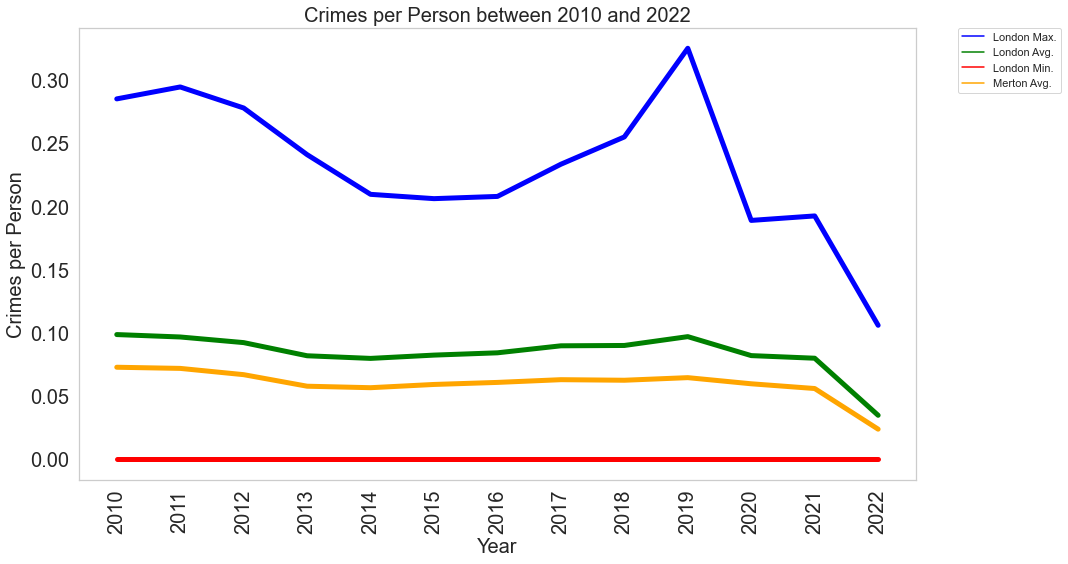

In [25]:
crime_plot

In [26]:
print(crime_narrative)


The 2022 crimes per person in Merton is 0.0238. This is below the average for London in the same period of 0.0348 and is significantly below the maximum of 0.1060. It is above the minimum of 0.0000. Over the period 2010 to 2022 crimes per person in Merton has greatly decreasd. Over the same period the population of Merton has slightly increased starting at 196,669 and ending at 233,264  which is an increase of 36,595. London's population has slightly increased from 8,054,622 and ending at 9,553,385  which is an increase of 1,498,763.


In [27]:
log.debug(f"{borough}")

print(f"The table below shows the major crime category for {borough} within the period, first to fith with totals")

2022-09-02 18:11:10,077 [DEBUG] __main__: Merton
The table below shows the major crime category for Merton within the period, first to fith with totals


In [28]:
borough_major_crime_data_df_html

,1st,2nd,3rd,4th,5th
Year,,,,,
2022,"Violence Against the Person - [1,748]","Theft - [1,113]",Vehicle Offences - [747],Arson and Criminal Damage - [412],Public Order Offences - [405]
2021,"Violence Against the Person - [4,207]","Theft - [2,485]","Vehicle Offences - [1,541]","Public Order Offences - [1,058]",Arson and Criminal Damage - [978]
2020,"Violence Against the Person - [4,149]","Theft - [2,283]","Vehicle Offences - [2,043]","Drug Offences - [1,019]","Public Order Offences - [1,007]"
2019,"Violence Against the Person - [3,935]","Theft - [3,098]","Vehicle Offences - [2,057]","Burglary - [1,587]","Arson and Criminal Damage - [1,099]"
2018,"Violence Against the Person - [3,649]","Theft - [3,134]","Vehicle Offences - [1,931]","Burglary - [1,549]","Arson and Criminal Damage - [1,131]"
2017,"Violence Against the Person - [3,560]","Theft - [3,235]","Vehicle Offences - [1,778]","Burglary - [1,442]","Arson and Criminal Damage - [1,245]"
2016,"Violence Against the Person - [3,304]","Theft - [3,083]","Vehicle Offences - [1,825]","Burglary - [1,418]","Arson and Criminal Damage - [1,385]"
2015,"Violence Against the Person - [3,222]","Theft - [3,112]","Vehicle Offences - [1,463]","Burglary - [1,427]","Arson and Criminal Damage - [1,393]"
2014,"Theft - [2,949]","Violence Against the Person - [2,521]","Burglary - [1,680]","Vehicle Offences - [1,664]","Arson and Criminal Damage - [1,227]"


In [29]:
print(crime_bump_chart_narrative)

How Merton ranks with the other London boroughs over the period 2010 to 2022 can be seen below. Ranking is top to bottom, with the top representing the highest crimes per person rate.


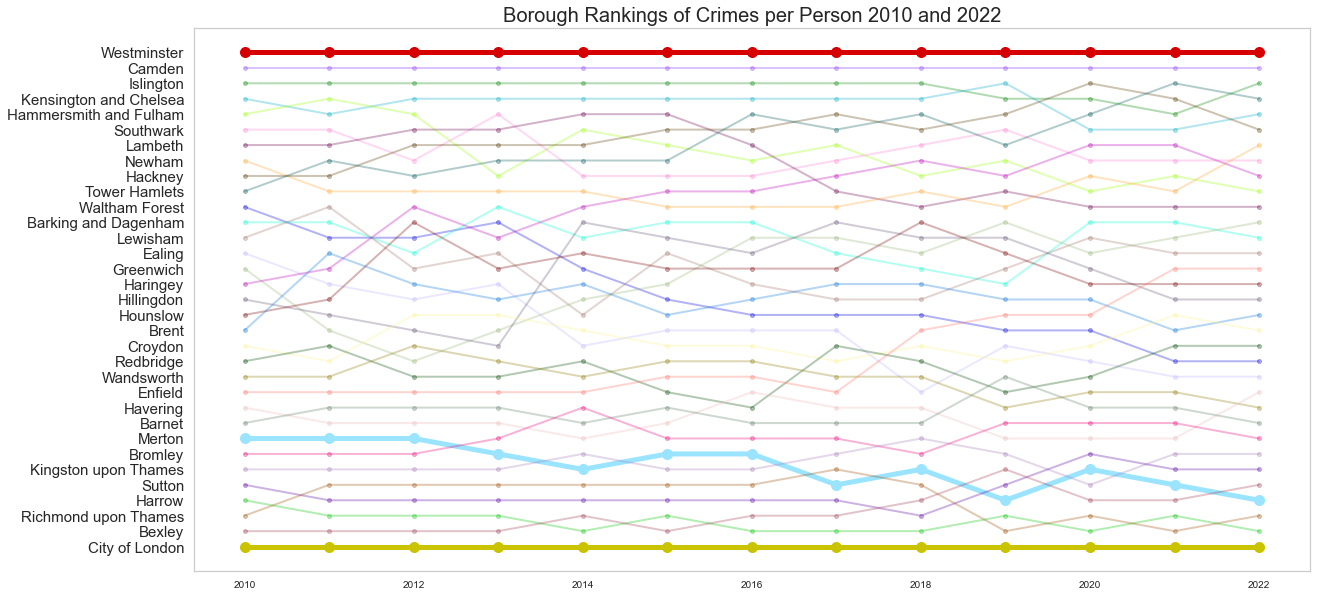

In [30]:
crime_bump_plot

In [31]:
crime_benchamark_data_df_html

,Borough with Lowest Crime per Person,Merton Crime per Person,Borough with Highest Crime per Person
Year,,,
2022,City of London - 0.0000,0.0238,Westminster - 0.1060
2021,City of London - 0.0000,0.0560,Westminster - 0.1926
2020,City of London - 0.0000,0.0597,Westminster - 0.1890
2019,City of London - 0.0000,0.0646,Westminster - 0.3253
2018,City of London - 0.0000,0.0625,Westminster - 0.2551
2017,City of London - 0.0000,0.0630,Westminster - 0.2335
2016,City of London - 0.0000,0.0608,Westminster - 0.2080
2015,City of London - 0.0000,0.0592,Westminster - 0.2063
2014,City of London - 0.0000,0.0566,Westminster - 0.2097


In [32]:
print("Crime by borough benchmark table")

Crime by borough benchmark table


# REPORT GENERATION

## ARTEFACTS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2022-09-03 13:05:31,375 [INFO] lib.db_tools: DATABASE CONNECTIVITY
2022-09-03 13:05:31,376 [DEBUG] root: Retrieving crime min max year
2022-09-03 13:05:31,441 [DEBUG] managers.sections.sd_report_section_07_Crime: 2001
2022-09-03 13:05:31,442 [DEBUG] managers.sections.sd_report_section_07_Crime: 2022
2022-09-03 13:05:31,442 [DEBUG] managers.sections.sd_report_section_07_Crime: crime orig_year_to    :2018
2022-09-03 13:05:31,443 [DEBUG] managers.sections.sd_report_section_07_Crime: crime search_year_to  :2018
2022-09-03 13:05:31,444 [DEBUG] managers.sections.sd_report_section_07_Crime: QRY Started
2022-09-03 13:05:31,445 [DEBUG] root: Retrieving Crime Ranked By Borough Years


C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


2022-09-03 13:06:18,157 [DEBUG] managers.sections.sd_report_section_07_Crime: QRY Ended
2022-09-03 13:06:18,162 [DEBUG] root: city_population
2022-09-03 13:06:18,183 [DEBUG] root: city_population


C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


2022-09-03 13:06:19,288 [DEBUG] managers.sections.sd_report_section_07_Crime: [[0.08921, 0.09075, 0.08356, 0.08966, 0.0878, 0.08616, 0.08791, 0.07986, 0.07059, 0.06882, 0.06547, 0.06689, 0.07609, 0.07524]]
2022-09-03 13:06:19,289 [DEBUG] managers.sections.sd_report_section_07_Crime: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
2022-09-03 13:06:19,295 [DEBUG] managers.sections.sd_report_section_07_Crime: slope:-0.0017843736263736258
2022-09-03 13:06:20,146 [DEBUG] matplotlib.axes._base: top of Axes not in the figure, so title not moved
2022-09-03 13:06:20,234 [DEBUG] matplotlib.axes._base: top of Axes not in the figure, so title not moved
2022-09-03 13:06:20,259 [DEBUG] matplotlib.axes._base: top of Axes not in the figure, so title not moved
2022-09-03 13:06:20,290 [DEBUG] matplotlib.axes._base: top of Axes not in the figure, so title not moved
2022-09-03 13:06:20,318 [DEBUG] matplotlib.axes._base: top of Axes not in the figure, so title not moved

C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


2022-09-03 13:06:40,315 [DEBUG] root: Retrieving Crim Major categories for a ward top 5 for borough in year


C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


2022-09-03 13:06:41,100 [DEBUG] managers.sections.sd_report_section_07_Crime: {'crime_time_series_plot': './reports/generation/images/SECTION_TEST_07_CRIME_crime_time_series_plot_London_2005_2018.png', 'crime_narrative_01': '', 'crime_narrative_02': "The 2018 crimes per person in Redbridge is 0.0752. This is below the average for London in the same period of 0.0901 and is significantly below the maximum of 0.2551. It is above the minimum of 0.0000. Over the period 2005 to 2018 crimes per person in Redbridge has slightly decreased. Over the same period the population of Redbridge has slightly increased from 258,521 to 308,545  which is an increase of 50,024. London's population has slightly increased from 7,578,999 and ending at 9,045,542 which is an increase of 1,466,543.", 'crime_bump_chart_plot': './reports/generation/images/SECTION_TEST_07_CRIME_crime_bump_chart_plot_London_2005_2018.png', 'crime_bump_chart_narrative_01': 'How Redbridge ranks with the other London boroughs over the 

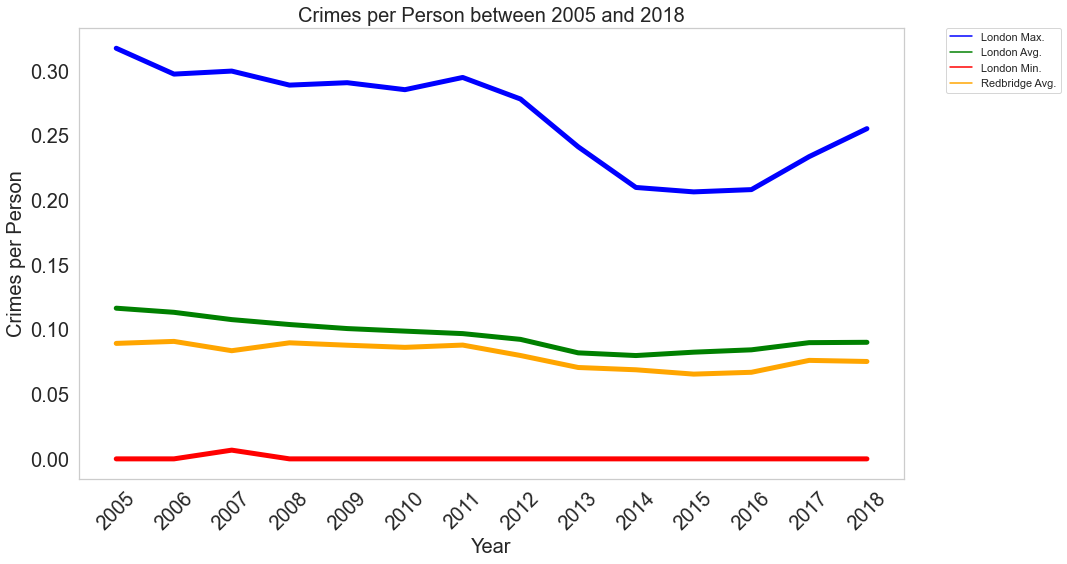

2022-09-03 13:06:41,546 [DEBUG] matplotlib.axes._base: top of Axes not in the figure, so title not moved
2022-09-03 13:06:41,750 [DEBUG] matplotlib.axes._base: top of Axes not in the figure, so title not moved
2022-09-03 13:06:41,839 [DEBUG] matplotlib.axes._base: top of Axes not in the figure, so title not moved
2022-09-03 13:06:41,940 [DEBUG] matplotlib.axes._base: top of Axes not in the figure, so title not moved
2022-09-03 13:06:41,989 [DEBUG] matplotlib.axes._base: top of Axes not in the figure, so title not moved


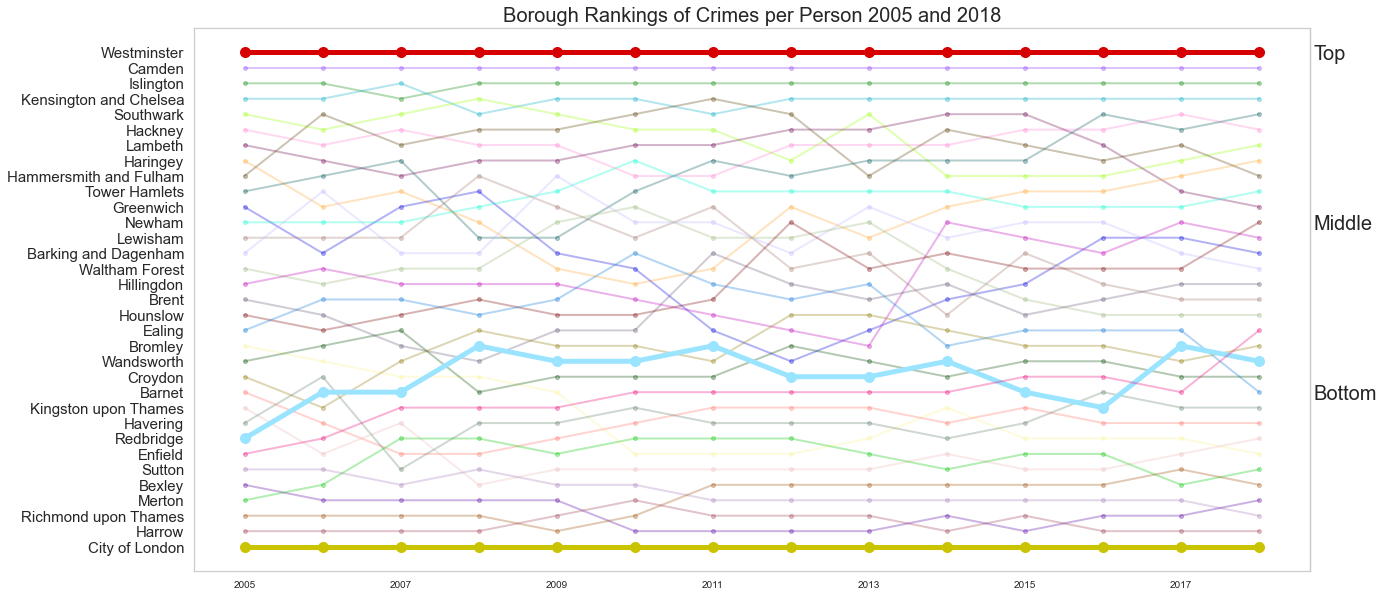

In [206]:
### Set up
%load_ext autoreload

%autoreload 3
from data.daos import dao_facade_local as dao_fac
from lib import masters_data_analytics_lib as mlib
from managers.sections import sd_report_section_07_Crime as report_section_crime

session_id = "SECTION_TEST_07_CRIME"
report_context = {}
# borough = "Tower Hamlets"
## Increasing
borough = "Westminster"
ward_name = "Hyde Park"

# borough = "Tower Hamlets"
# ward_name = "Limehouse"

borough = "Redbridge"
ward_name = "Chadwell"

## min 2001 max 2022
##                                             0.001 >= is seen as an increase/decrease
## Westminster   2014 - 2016 - flat     slope -0.000 8249999999999924
##               2018 - 2020 - decrease slope -0.041 510000000000005 
##               2016 - 2018 - increase slope  0.023 544999999999996
## Tower Hamlets 2001 - 2022 - decrease slope -0.002 5789045736871827
##               2014 - 2019 - increase slope  0.004 301714285714286
##               2005 - 2007 - flat     slope -0.000 1850000000000046 
                

year_from = 2005
year_to   = 2018

search_term = {
    "city"      : city
  , "borough"   : borough
  , "ward_name" : ward_name
  , "year_to"   : year_to
  , "year_from" : year_from
}

report_section_crime.generate_report_section(session_id     = session_id
                      , search_term    = search_term
                      , report_context = report_context
                      , properties     = properties 
                      , dao_fac        = dao_fac)  
log.debug(report_context)

## REPORT

In [207]:
%load_ext autoreload

%autoreload 3

from managers import sd_report_manager as report_man

report_context_new = {"template_processor_file_name":"./reports/processors/sd_test_generation_07_crime.json",
                      "report_option":1} 

report_context_new["city"] = city
report_context_new["borough"] = borough
report_context_new["ward_name"] = ward_name
report_context_new["year_to"] = year_to
report_context_new["year_from"] = year_from

report_context.update(report_context_new)

log.debug("Started")
generated_report = report_man.generate_report(session_id
                                            , report_context = report_context
                                            , properties = properties)
log.debug("Finished")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2022-09-03 13:07:21,215 [DEBUG] managers.sections.sd_report_section_07_Crime: Started
2022-09-03 13:07:21,260 [DEBUG] managers.sd_report_manager: text_alignment:justify
2022-09-03 13:07:21,351 [WARNING] managers.sd_report_manager: Not a Command
2022-09-03 13:07:21,352 [WARNING] managers.sd_report_manager: Not a Command
2022-09-03 13:07:21,420 [WARNING] managers.sd_report_manager: Not a Command
2022-09-03 13:07:21,422 [DEBUG] managers.sd_report_manager: text_alignment:justify
2022-09-03 13:07:21,423 [WARNING] managers.sd_report_manager: Not a Command
2022-09-03 13:07:21,502 [DEBUG] managers.sd_report_manager: text_alignment:justify
2022-09-03 13:07:21,504 [WARNING] managers.sd_report_manager: Not a Command
2022-09-03 13:07:21,804 [WARNING] managers.sd_report_manager: Not a Command
2022-09-03 13:07:21,805 [WARNING] managers.sd_report_manager: Not a Command
2022-09-03 13:07:21,899 [DEBUG] managers.sd_r